In [1]:
import os
import sys
sys.path.insert(0,'/home/junwoony/Desktop/Differentiable_Optimization_GCN/Differentiable_Optimization_GCN/')

import numpy as np
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0
%env CUDA_LAUNCH_BLOCKING=1

import mongo
import time
import pickle
import random
import numpy as np
import tqdm
import copy
import matplotlib.pyplot as plt
import multiprocess as mp

from pymatgen.io.ase import AseAtomsAdaptor

import torch
from torch.nn.utils import clip_grad_norm_
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam, SGD
from torch.optim.lbfgs import LBFGS
from cgcnn.data_orbital_sigopt import StructureData, ListDataset, StructureDataTransformer, collate_pool, MergeDataset
from cgcnn.model_sigopt import CrystalGraphConvNet

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ShuffleSplit, train_test_split
from sklearn.metrics import get_scorer
from skorch import NeuralNetRegressor
from skorch.callbacks import Checkpoint, LoadInitState #needs skorch 0.4.0, conda-forge version at 0.3.0 doesn't cut it
import skorch.callbacks.base
from skorch.dataset import CVSplit
from skorch.callbacks.lr_scheduler import WarmRestartLR, LRScheduler

from utils.adamwr.adamw import AdamW
from utils.adamwr.cosine_scheduler import CosineLRWithRestarts


from sigopt_sklearn.search import SigOptSearchCV


env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0
env: CUDA_LAUNCH_BLOCKING=1


In [2]:
SDT_list = pickle.load(open('../../inputs/input_7_nbrs_40_steps/SDT_list.pkl', 'rb'))
docs = pickle.load(open('../../inputs/input_7_nbrs_40_steps/final_docs.pkl', 'rb'))

target_list = []
for sdt in SDT_list:
    free_atom_idx = sdt[-2]
    target_list.append(sdt[-1][free_atom_idx].numpy())
target_list = np.array(target_list).reshape(-1,1)

structures = SDT_list[0]
orig_atom_fea_len = structures[0].shape[-1]
nbr_fea_len = structures[1].shape[-1]


In [3]:
SDT_training, SDT_test, target_training, target_test, docs_training, docs_test \
= train_test_split(SDT_list, target_list, docs, test_size=0.1, random_state=42)

In [4]:
# atom_fea = SDT_list[0][0]
# nbr_fea = SDT_list[0][1]
# nbr_fea_idx = SDT_list[0][2]
# nbr_fea_offset = SDT_list[0][3]
# atom_pos =SDT_list[0][4]
# nbr_pos = SDT_list[0][5] 
# atom_pos_idx = SDT_list[0][6]
# cells = SDT_list[0][7]
# fixed_base = SDT_list[0][8]
# free_atom_idx = SDT_list[0][9]
# atom_pos_final = SDT_list[0][10]


In [5]:
cuda = torch.cuda.is_available()
if cuda:
    device = torch.device("cuda")
else:
    device='cpu'

#Make a checkpoint to save parameters every time there is a new best for validation lost
cp = Checkpoint(monitor='valid_loss_best',fn_prefix='./surface_slab_harmonic2/valid_best_')

#Callback to load the checkpoint with the best validation loss at the end of training

class train_end_load_best_valid_loss(skorch.callbacks.base.Callback):
    def on_train_end(self, net, X, y):
        net.load_params('./surface_slab_harmonic2/valid_best_params.pt')
        
load_best_valid_loss = train_end_load_best_valid_loss()
print('device:', device)

device: cuda


In [6]:
def diff(sdt, target):
    fixed_base = sdt[8]
    free_atom_idx = np.where(fixed_base == 0)[0]
    free_atom_idx = torch.LongTensor(free_atom_idx)   
    diff = np.sum(((target[0] - sdt[4].numpy()[free_atom_idx]))**2.,axis=1)**0.5 
    return diff

np.mean(np.abs(np.concatenate([diff(sdt, target) for sdt,target in zip(SDT_list, target_list)])))

0.122171804

In [7]:
def diff_position(sdt, target):
    fixed_base = sdt[8]
    free_atom_idx = np.where(fixed_base == 0)[0]
    free_atom_idx = torch.LongTensor(free_atom_idx)   
    diff = (target[0] - sdt[4].numpy()[free_atom_idx])
    return diff

differences = []
for sdt, target in zip(SDT_list, target_list):
    differences.append(diff_position(sdt, target))
differences = np.concatenate(differences)
np.mean(np.abs(differences))

0.054590654

In [8]:
train_test_splitter = ShuffleSplit(test_size=0.1, random_state=42)

batchsize = 100
# warm restart scheduling from https://arxiv.org/pdf/1711.05101.pdf
LR_schedule = LRScheduler(CosineLRWithRestarts, batch_size=batchsize, epoch_size=len(SDT_training), restart_period=10, t_mult=1.2)

#############
# To extract intermediate features, set the forward takes only the first return value to calculate loss
class MyNet(NeuralNetRegressor):
    def get_loss(self, y_pred, y_true, **kwargs):        
        y_pred = y_pred[0] if isinstance(y_pred, tuple) else y_pred  # discard the 2nd output
        differ=torch.sum((y_pred - y_true.cuda())**2.0,dim=1)
        if torch.nonzero(differ).shape[0] != differ.shape[0]:
            print('zero sqrt for Loss')

        differ = torch.clamp(differ, min=1e-8)
        return torch.mean(torch.sqrt(differ))

net = MyNet(
    CrystalGraphConvNet,
    module__orig_atom_fea_len = orig_atom_fea_len,
    module__nbr_fea_len = nbr_fea_len,
    batch_size=batchsize, #214
    module__classification=False,
    lr=0.0056,
    max_epochs= 500,
    module__energy_mode="Harmonic", #["Harmonic", "Morse", "LJ"], Default = "Harmonic"
    module__atom_fea_len=46, #46,
    module__h_fea_len=83,
    module__h_fea_len_dist=83,
    module__h_fea_len_const=83,
    module__h_fea_len_D=83,
    module__n_conv=6, #8
    module__n_h_dist=8,
    module__n_h_const=8,
    module__n_h_D=8,
    module__max_num_nbr=12, #9
    module__opt_step_size=0.3, #0.3
    module__min_opt_steps=30,
    module__max_opt_steps=300,
    module__momentum=0.8,
    optimizer__weight_decay=1e-3,
    optimizer=AdamW,
    iterator_train__pin_memory=True,
    iterator_train__num_workers=0,
    iterator_train__shuffle=True,
    iterator_train__collate_fn = collate_pool,
    iterator_valid__pin_memory=True,
    iterator_valid__num_workers=0,
    iterator_valid__collate_fn = collate_pool,
    device=device,
#     criterion=torch.nn.MSELoss,
    criterion=torch.nn.L1Loss,
    dataset=MergeDataset,
    train_split = CVSplit(cv=train_test_splitter),
    callbacks=[cp, LR_schedule, load_best_valid_loss]
)
net.initialize()
net.load_params(f_history = './surface_slab_harmonic2/valid_best_history.json',
               f_optimizer = './surface_slab_harmonic2/valid_best_optimizer.pt',
               f_params = './surface_slab_harmonic2/valid_best_params.pt')

In [10]:
net.initialize()
net.fit(SDT_training, target_training)

Re-initializing module because the following parameters were re-set: atom_fea_len, classification, energy_mode, h_fea_len, h_fea_len_D, h_fea_len_const, h_fea_len_dist, max_num_nbr, max_opt_steps, min_opt_steps, momentum, n_conv, n_h_D, n_h_const, n_h_dist, nbr_fea_len, opt_step_size, orig_atom_fea_len.
Re-initializing optimizer because the following parameters were re-set: weight_decay.
blow up
blow up
  epoch    train_loss    valid_loss    cp       dur
-------  ------------  ------------  ----  --------
      1        0.9093        1.8402     +  285.3992
blow up
blow up
blow up
blow up
      2        1.5457        0.4217     +  353.3929
blow up
blow up
blow up
blow up
blow up
blow up
blow up
blow up
blow up
blow up
blow up
blow up
blow up
blow up
blow up
      3        0.4387        0.6599        242.6621
blow up
blow up
blow up
blow up
blow up
      4        0.5306        0.2629     +  238.2346
      5        0.2264        0.1735     +  207.0725
      6        0.1505        0.1481  

    134        0.0840        0.0906        84.6439
    135        0.0840        0.1129        76.3375
    136        0.0890        0.0832        83.4143
    137        0.0830        0.0820        87.7290
    138        0.0841        0.0858        80.2441
    139        0.0894        0.0879        87.1121
    140        0.0804        0.0851        81.5386
    141        0.0770        0.0853        83.8086
    142        0.0827        0.0847        79.1177
    143        0.0797        0.0823        78.7545
    144        0.0756        0.0922        84.7394
    145        0.0773        0.1091        84.9418
    146        0.0785        0.0789     +  78.4321
    147        0.0717        0.0794        85.9226
    148        0.0768        0.0873        82.6602
    149        0.0759        0.0833        72.6876
    150        0.0769        0.0772     +  82.8383
    151        0.0749        0.0791        85.3816
    152        0.0733        0.0766     +  87.4208
    153        0.0728        0.

    288        0.0615        0.0904        33.4310
    289        0.0659        0.0725        36.6947
    290        0.0656        0.0807        36.4099
    291        0.0632        0.0756        35.1100
    292        0.0621        0.0708        33.1181
    293        0.0602        0.0717        33.7198
    294        0.0584        0.0825        34.5700
    295        0.0587        0.0698        36.2929
    296        0.0604        0.0690        32.9684
    297        0.0576        0.0707        35.8311
    298        0.0589        0.0737        34.8728
    299        0.0588        0.0710        34.5565
    300        0.0547        0.0695        34.0523
    301        0.0574        0.0699        35.3289
    302        0.0561        0.0686     +  33.1720
    303        0.0574        0.0683     +  34.1559


RuntimeError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 11.78 GiB total capacity; 2.05 GiB already allocated; 4.88 MiB free; 215.39 MiB cached)

In [9]:
client_token = "TSRIPFKLRAIMUDDVQEBJHVBQRVBCDJOSKJMKEQTXWCYZDNED"
net_parameters = {
                'batch_size':(20,120),
                'lr':(np.exp(-15),np.exp(-3)),
                'max_epochs':(50,300),
                'module__atom_fea_len':(3,256), #46,
                'module__h_fea_len':(3,256),
                'module__h_fea_len_dist':(3,256),
                'module__h_fea_len_const':(3,256),
                'module__h_fea_len_D':(3,256),
                'module__n_conv':(1,12), #8
                'module__n_h_dist':(1,12),
                'module__n_h_const':(1,12),
                'module__n_h_D':(1,12),
                'module__opt_step_size':(0.1,0.7),
                'optimizer__weight_decay':(np.exp(-10),np.exp(-2))
                }

cv=ShuffleSplit(n_splits=1, test_size=0.1)

clf = SigOptSearchCV(net, net_parameters, cv=train_test_splitter, client_token=client_token,
                    n_jobs=1, n_iter=50, scoring=get_scorer('neg_mean_absolute_error'))

clf.fit(SDT_training, target_training)

/home/junwoony/miniconda3/envs/schnet2/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:82: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


  epoch    train_loss    valid_loss    cp      dur
-------  ------------  ------------  ----  -------
      1        0.1185        0.1218     +  32.2326
      2        0.1203        0.1210     +  31.6294
      3        0.1190        0.1211        31.7579
      4        0.1180        0.1211        31.8141


KeyboardInterrupt: 

In [11]:
SDT_train, SDT_valid, target_train, target_valid = train_test_split(SDT_training, target_training, 
                                                                    test_size=0.1, random_state=42)
def get_targets(dummy_SDT, dummy_targets):
    targets = []
    for i, target in enumerate(dummy_targets):
        free_atom_idx = dummy_SDT[i][-2]
        
        targets.append(target[0].reshape(-1,3))
    return np.concatenate(targets)

def get_distance(pred, true):
    diff = np.sum((pred - true)**2, axis=1)
    return np.sqrt(diff)

In [12]:
pred_train = net.predict(SDT_train)
true_train = get_targets(SDT_train, target_train)
distance_train = get_distance(pred_train, true_train)
MAE_train = np.mean(distance_train)

# pred_val = net.predict(SDT_valid)
# true_val = get_targets(SDT_valid, target_valid)
# distance_val = get_distance(pred_val, true_val)
# MAE_val = np.mean(distance_val)

pred_test = net.predict(SDT_test)
true_test = get_targets(SDT_test, target_test)
distance_test = get_distance(pred_test, true_test)
MAE_test = np.mean(distance_test)

In [13]:
np.mean(np.abs(pred_test - true_test))

0.0338591

In [14]:
differences = []
for sdt, target in zip(pred_test, true_test):
    differences.append(diff_position(sdt, target))
differences = np.concatenate(differences)
np.mean(np.abs(differences))

IndexError: index 8 is out of bounds for axis 0 with size 3

In [16]:
print(MAE_test, MAE_test)

0.074342854 0.074342854


In [17]:
print(len(SDT_train), len(SDT_valid), len(SDT_test))

3709 413 459


Text(0.5, 1.0, 'test result')

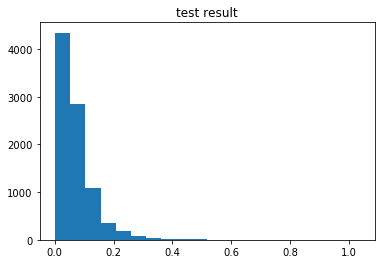

In [14]:
plt.hist(distance_test, bins=20)
plt.title('test result')

In [18]:
docs_train, docs_val = train_test_split(docs_training, test_size=0.1, random_state=42)

In [19]:
def analysis(SDT, docs, distance):
    dist_per_surface = []
    total_atoms = 0
    for sdt in SDT:
        num_atoms = sdt[-2].shape[0]
        dist_per_surface.append(np.mean(distance[total_atoms: total_atoms+num_atoms]))
        total_atoms += num_atoms
    results =[]
    reduced = []
    best = []
    bad_docs = []
    bad_result =[]
    good_docs=[]
    good_result=[]
    f = 0
    for dist, doc in zip(dist_per_surface, docs):
        total_steps = len(doc['distances_per_step'])
        reduced_steps = len(np.where(doc['distances_per_step'] >= dist)[0])
        results.append([total_steps, reduced_steps, reduced_steps/total_steps])
        reduced.append(reduced_steps/total_steps)
        if reduced_steps/total_steps < 0.1:
            bad_docs.append(doc)
            bad_result.append([total_steps, reduced_steps, reduced_steps/total_steps, dist])
        else:
            good_docs.append(doc)
            good_result.append([total_steps, reduced_steps, reduced_steps/total_steps,dist])
    
    return results, reduced, bad_docs, bad_result,good_docs, good_result

In [20]:
results, reduced, bad_docs, bad_result,good_docs,good_result = analysis(SDT_test, docs_test, distance_test)

In [21]:
good_result

[[26, 5, 0.19230769230769232, 0.1175502],
 [26, 6, 0.23076923076923078, 0.15778206],
 [19, 6, 0.3157894736842105, 0.027491713],
 [15, 4, 0.26666666666666666, 0.04570685],
 [32, 9, 0.28125, 0.10456716],
 [19, 3, 0.15789473684210525, 0.06258627],
 [18, 4, 0.2222222222222222, 0.07884418],
 [34, 9, 0.2647058823529412, 0.17137583],
 [17, 5, 0.29411764705882354, 0.031291526],
 [21, 11, 0.5238095238095238, 0.055237968],
 [18, 4, 0.2222222222222222, 0.039373104],
 [25, 10, 0.4, 0.10506768],
 [12, 4, 0.3333333333333333, 0.04470617],
 [22, 4, 0.18181818181818182, 0.07571136],
 [26, 12, 0.46153846153846156, 0.09256738],
 [28, 5, 0.17857142857142858, 0.055534203],
 [11, 4, 0.36363636363636365, 0.0897941],
 [20, 4, 0.2, 0.058384757],
 [9, 1, 0.1111111111111111, 0.05287528],
 [14, 4, 0.2857142857142857, 0.084015235],
 [14, 3, 0.21428571428571427, 0.0542026],
 [18, 9, 0.5, 0.055651605],
 [21, 4, 0.19047619047619047, 0.046196893],
 [12, 2, 0.16666666666666666, 0.04654707],
 [16, 7, 0.4375, 0.012803385

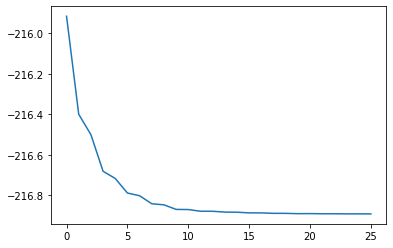

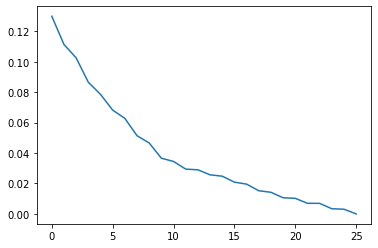

In [20]:
plt.plot(good_docs[3]['energies_per_step'])
plt.show()
plt.plot(good_docs[3]['distances_per_step'])
plt.show()


In [ ]:
results, reduced, bad_docs, bad_result,good_docs,good_result = analysis(SDT_valid, docs_val, distance_val)

Text(0.5, 0, '% Reduced')

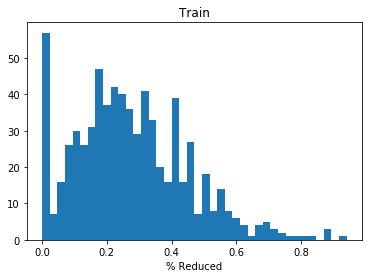

In [21]:
import matplotlib.pyplot as plt
plt.hist(reduced, bins=40)
plt.title("Train")
plt.xlabel("% Reduced")

In [22]:
docs_train[0]['data']

'slab'

In [23]:
f = []
for doc in good_docs:
    f.append(doc['data'])

In [24]:
import collections
collections.Counter(f)

Counter({'surface': 228, 'slab': 367})

In [22]:
np.mean(reduced)

0.23540377362260173

In [26]:
natoms =[]
types = []
steps = []
distances = []
filtered_idx = []

for doc in bad_docs:
    natoms.append(doc['atoms']['natoms'])
    types.extend(doc['atoms']['chemical_symbols'])
    atoms = mongo.make_atoms_from_doc(doc, is_initial=True)
    atoms_final = mongo.make_atoms_from_doc(doc, is_initial=False)
    if atoms.constraints:
        fixed_atom_idx = atoms.constraints[0].index
        base = np.ones(len(atoms.positions))
        base[fixed_atom_idx] = 0
        free_atom_idx = np.where(base==1)[0]
        
    else:
        free_atom_idx = np.arange(len(atoms))
    difference = atoms.positions[free_atom_idx] - atoms_final.positions[free_atom_idx]
    dist = np.sqrt(np.sum(difference**2, axis=1))
    distances.append(dist)    
    if np.mean(dist) > 0.05:
        filtered_idx.append(doc['idx'])

In [27]:
d_mean=[]
for dist in distances:
    d_mean.append(np.mean(dist))

(array([9., 5., 9., 3., 2., 2., 7., 8., 2., 4., 7., 4., 3., 2., 1., 1., 3.,
        2., 1., 5., 3., 1., 1., 3., 1., 1., 1., 2., 0., 2., 0., 0., 1., 0.,
        1., 1., 1., 1., 2., 3., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1.]),
 array([0.04009705, 0.04491276, 0.04972846, 0.05454417, 0.05935988,
        0.06417559, 0.06899129, 0.073807  , 0.07862271, 0.08343841,
        0.08825412, 0.09306983, 0.09788553, 0.10270124, 0.10751695,
        0.11233266, 0.11714836, 0.12196407, 0.12677978, 0.13159548,
        0.13641119, 0.1412269 , 0.14604261, 0.15085831, 0.15567402,
        0.16048973, 0.16530543, 0.17012114, 0.17493685, 0.17975255,
        0.18456826, 0.18938397, 0.19419968, 0.19901538, 0.20383109,
        0.2086468 , 0.2134625 , 0.21827821, 0.22309392, 0.22790962,
        0.23272533, 0.23754104, 0.24235675, 0.24717245, 0.25198816,
        0.25680387, 0.26161957, 0.26643528, 0.27125099, 0.2760667 ,
        0.2808824 ]),
 <a list of 50 Patch objects>)

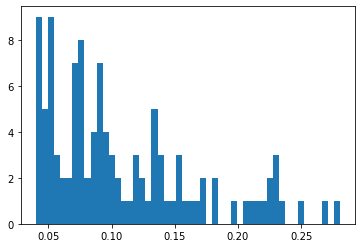

In [28]:
plt.hist(d_mean, bins=50)

(array([9., 5., 9., 3., 2., 2., 7., 8., 2., 4., 7., 4., 3., 2., 1., 1., 3.,
        2., 1., 5., 3., 1., 1., 3., 1., 1., 1., 2., 0., 2., 0., 0., 1., 0.,
        1., 1., 1., 1., 2., 3., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1.]),
 array([0.04009705, 0.04491276, 0.04972846, 0.05454417, 0.05935988,
        0.06417559, 0.06899129, 0.073807  , 0.07862271, 0.08343841,
        0.08825412, 0.09306983, 0.09788553, 0.10270124, 0.10751695,
        0.11233266, 0.11714836, 0.12196407, 0.12677978, 0.13159548,
        0.13641119, 0.1412269 , 0.14604261, 0.15085831, 0.15567402,
        0.16048973, 0.16530543, 0.17012114, 0.17493685, 0.17975255,
        0.18456826, 0.18938397, 0.19419968, 0.19901538, 0.20383109,
        0.2086468 , 0.2134625 , 0.21827821, 0.22309392, 0.22790962,
        0.23272533, 0.23754104, 0.24235675, 0.24717245, 0.25198816,
        0.25680387, 0.26161957, 0.26643528, 0.27125099, 0.2760667 ,
        0.2808824 ]),
 <a list of 50 Patch objects>)

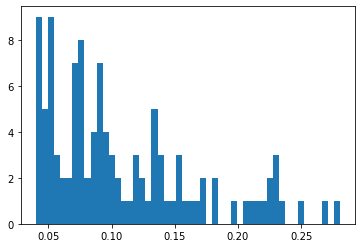

In [29]:
plt.hist(d_mean, bins=50)

In [48]:
len(distances)

158